In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np

import pystorm
from pystorm.hal.net_builder import NetBuilder
from pystorm.hal.run_control import RunControl
from pystorm.hal.calibrator import Calibrator, PoolSpec
from pystorm.hal.data_utils import lpf, bin_to_spk_times, bins_to_rates

import utils

In [2]:
DATA_DIR = "data/test_accumulator_decodes/tuning/"

# X = 16
# Y = 16

X = 32
Y = 32

TRAINING_DOWNSTREAM_NS = 10000 # minimum time resolution, downstream time resolution
TRAINING_UPSTREAM_NS   = 1000000 # default upstream time resolution
FMAX_IN = 2000
TUNING_INPUT_POINTS = 1200 # number of input points to take for collecting tuning data
TUNING_POINT_TIME_NS = int(2*1E9) # time to record data per tuning curve input point
DISCARD_FRAC = 0.25
N_DATASETS = 18

PS_ORIG = PoolSpec(
    label = "pool",
    YX = (Y, X),
    loc_yx = (0, 0),
    D = 1,
)
SET_IDX = 4

FNAME_BASE = (DATA_DIR + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) +
             "_fmax_in_" + str(FMAX_IN) + "_samples_" +
             str(TUNING_INPUT_POINTS) + "_sample_time_" + str(TUNING_POINT_TIME_NS//1000000) + "ms"
             "_discard_" + str(DISCARD_FRAC))
FNAME = FNAME_BASE + "_set_" + str(SET_IDX) +".pck"

In [3]:
def build_net(net_builder, ps_orig):
    with open("data/test_accumulator_decodes/" +
              ps_orig.label + "_" + str(ps_orig.YX) + "_" + str(ps_orig.loc_yx) +
              ".pck", 'rb') as fhandle:
        ps_opt, est_enc, est_off = pickle.load(fhandle)
    d_matrix = np.zeros((2, Y*X))    
    net = net_builder.create_single_pool_net_from_spec(ps_opt, d_matrix)
    return net

HAL = pystorm.hal.HAL()
NET_BUILDER = NetBuilder(HAL)
NET = build_net(NET_BUILDER, PS_ORIG)
RUN_CONTROL = RunControl(HAL, NET)
HAL.map(NET)

In [4]:
class TuningData:
    def __init__(self, input_rates, spike_rates):
        self.input_rates = input_rates
        self.spike_rates = spike_rates

def sweep_inputs_collect_spikes(net, hal, run_control, input_points,
                                fmax_in, time_per_point_ns):
    """Collect tuning data to be used when fitting decoders"""
    n_pts = len(input_points)
    time_points_ns = np.arange(n_pts+1)*time_per_point_ns
    input_rates = np.zeros((n_pts+1, 1))
    input_rates[:n_pts, 0] = fmax_in*input_points
    input_rates[-1, 0] = input_rates[-2, 0]
    input_data = {net.input:(time_points_ns, input_rates)}

    _, spike_data = run_control.run_input_sweep(
        input_data, get_raw_spikes=True, get_outputs=False)
    spikes, bin_times_ns = spike_data
    spikes = spikes[net.pool]    
    spike_rates = bins_to_rates(spikes, bin_times_ns,
                                time_points_ns, init_discard_frac=DISCARD_FRAC)
    return input_rates[:-1], spike_rates

def collect_tuning_data(net, hal, run_control,
                        n_input_points, time_per_point_ns,
                        fmax_in):
    """Collect tuning data to be used when fitting decoders"""
    hal.set_time_resolution(TRAINING_DOWNSTREAM_NS, TRAINING_UPSTREAM_NS)
    N_PERIODS = 5
    tuning_input_points = np.zeros(n_input_points)
    period_length = n_input_points//N_PERIODS
    input_base = np.linspace(-1, 1, period_length)
    input_rep = np.zeros(period_length)
    input_rep[:period_length//2] = input_base[::2]
    input_rep[period_length//2:] = input_base[1::2][::-1]
    tuning_input_points = np.tile(input_rep, N_PERIODS)
    
    tuning_input_rates, tuning_spike_rates = sweep_inputs_collect_spikes(
        net, hal, run_control, tuning_input_points, fmax_in, time_per_point_ns)
    tuning_data = TuningData(tuning_input_rates, tuning_spike_rates)
    return tuning_data
    

In [5]:
def build_dataset(fname):
    tuning_data = collect_tuning_data(
        NET, HAL, RUN_CONTROL,
        TUNING_INPUT_POINTS, TUNING_POINT_TIME_NS,
        FMAX_IN)
    with open(fname, 'wb') as fhandle:
        pickle.dump(tuning_data, fhandle)

def plot_dataset(fname):
    with open(fname, 'rb') as fhandle:
        tuning_data = pickle.load(fhandle)
    plt.figure()
    plt.plot(tuning_data.input_rates, tuning_data.spike_rates)

In [6]:
build_dataset(FNAME)

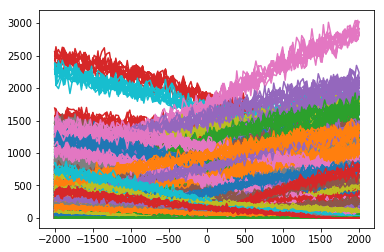

In [7]:
plot_dataset(FNAME)